In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import seaborn as sns


%matplotlib inline  

In [2]:
import sklearn
print(sklearn.__version__)

0.20.0


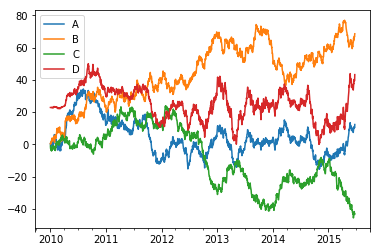

In [3]:
rng = np.random.RandomState(4)

# Simulate dataset
df_raw = pd.DataFrame(1 * rng.randn(2000, 3),
                  index=pd.date_range('1/1/2010', periods=2000), 
                  columns=list('ABC'))

df_raw = df_raw.cumsum()
df_raw['D'] = df_raw['A'] * df_raw['B'] + df_raw['C']
df_raw['D'] = ((df_raw['D']-df_raw['D'].min()) / (df_raw['D'].max() -df_raw['D'].min())) * 50
df_raw.plot()

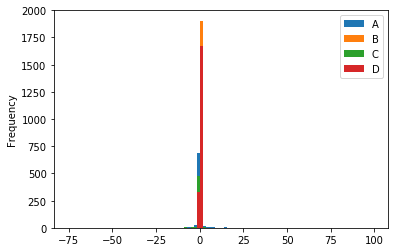

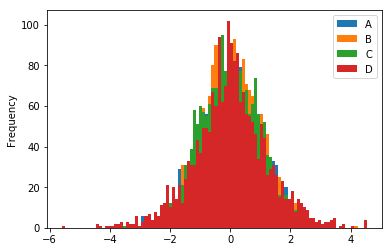

In [4]:
# feature creation
df_raw.pct_change().replace([np.inf, -np.inf], np.nan).plot.hist(bins = 100)
df_raw.diff().plot.hist(bins = 100)

In [5]:
df = df_raw.join(
    df_raw.diff(), rsuffix = '_diff').join(
    df_raw.pct_change().replace([np.inf, -np.inf], np.nan), rsuffix = '_pct_change')

df.fillna(df.median(), inplace=True)

In [6]:
df.head()

,A,B,C,D,A_diff,B_diff,C_diff,D_diff,A_pct_change,B_pct_change,C_pct_change,D_pct_change
2010-01-01,0.050562,0.499951,-0.995909,22.834362,0.015507,0.056073,-0.033267,-0.001395,-0.007830,0.001543,0.000779,-0.000084
2010-01-02,0.744160,0.081650,-2.580486,22.794834,0.693599,-0.418302,-1.584577,-0.039528,13.717862,-0.836684,1.591086,-0.001731
2010-01-03,0.096453,0.680225,-2.248236,22.803435,-0.647707,0.598575,0.332250,0.008602,-0.870386,7.331005,-0.128755,0.000377
2010-01-04,-1.051023,1.298895,-2.336223,22.764682,-1.147477,0.618670,-0.087987,-0.038754,-11.896689,0.909507,0.039136,-0.001699
2010-01-05,-0.625951,1.631148,-3.493039,22.743945,0.425072,0.332253,-1.156816,-0.020737,-0.404437,0.255797,0.495165,-0.000911


In [7]:
df_train = df[df.index < '1/1/2014']
df_test = df[df.index >= '1/1/2014']

(<matplotlib.axes._subplots.AxesSubplot at 0x7fae2650fda0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae26211390>)

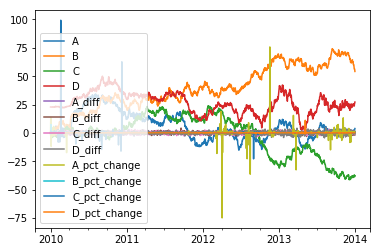

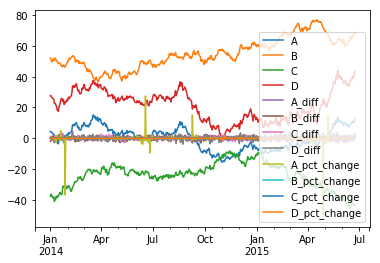

In [8]:
df_train.plot(), df_test.plot()

In [9]:
# fit the model
clf = IsolationForest(
    n_estimators = 100,
    behaviour='new',
    max_samples='auto', # 'auto':=  max_samples=min(256, n_samples)
    random_state=rng, 
    contamination=0.01) #'auto'

In [10]:
y_pred = 'is_outlier'
y_anomaly_score = 'anomaly_score'
#X = 'A B C D A_diff B_diff C_diff D_diff A_pct_change B_pct_change C_pct_change D_pct_change'.split()
X = 'A B C D'.split()
#X = ['B']

In [11]:
clf.fit(df_train[X])
df_train[y_pred] = clf.predict(df_train[X])
df_test[y_pred] = clf.predict(df_test[X])
df_train[y_anomaly_score] = clf.decision_function(df_train[X]) # The lower, the more abnormal. neg is outlier
df_test[y_anomaly_score] = clf.decision_function(df_test[X])

/home/ejohnson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ejohnson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/ejohnson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

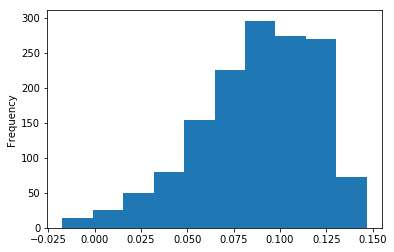

In [12]:
df_train[y_anomaly_score].plot.hist()

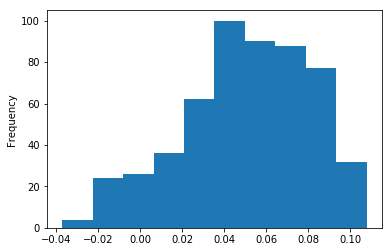

In [13]:
df_test[y_anomaly_score].plot.hist()

In [14]:
def outlier_hist(df, col):
    sns.distplot( df[df[y_pred]==-1][col] , color="skyblue", label="Outliers")
    sns.distplot( df[df[y_pred] != -1][col] , color="red", label="Inliers")
    plt.legend()
    plt.show()

/home/ejohnson/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


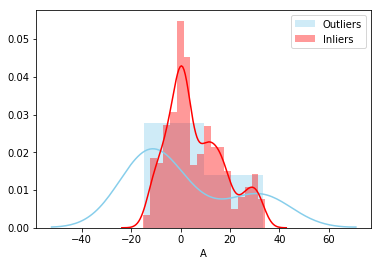

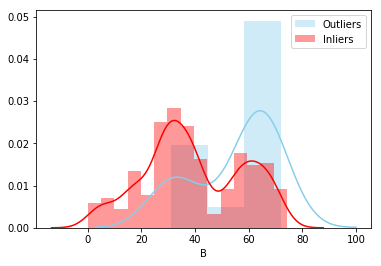

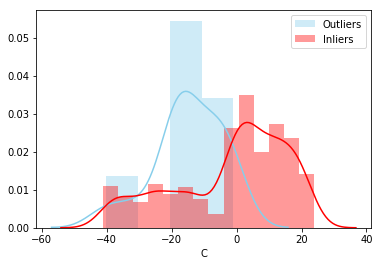

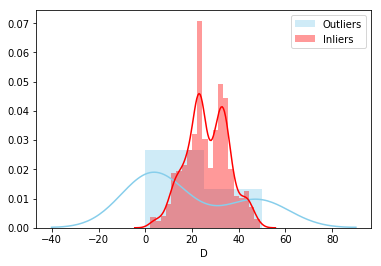

In [15]:
for var in 'A B C D'.split():
    outlier_hist(df_train, var)

# Explanation of outliers
* Methodology must take bi-modal distributions into account
* Therefore percentiles and distances from the mean are not ideal
### Idea 1:
* Use histogram binning of univariate space: bins with relatively low counts 
* This would be similar to fitting an isolation forest on a single variable and using the output from 'decision_function' to rank the features in how much they contribute to the point being an outlier

In [16]:
def single_col_fit(df, col):
    X = [col]
    clf.fit(df_train[X])
    y = '{}_anomaly_score'.format(col)
    df_train[y] = clf.decision_function(df_train[X]) # The lower, the more abnormal. neg is outlier
    df_test[y] = clf.decision_function(df_test[X])

In [17]:
for var in 'A B C D'.split():
    single_col_fit(df_train, var)

/home/ejohnson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ejohnson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ejohnson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

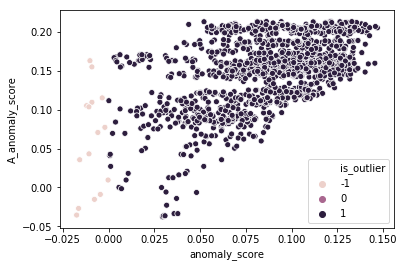

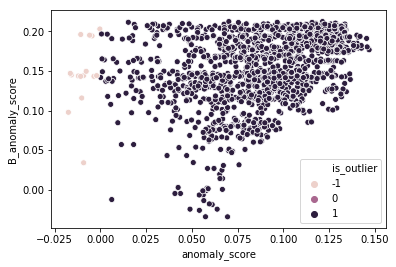

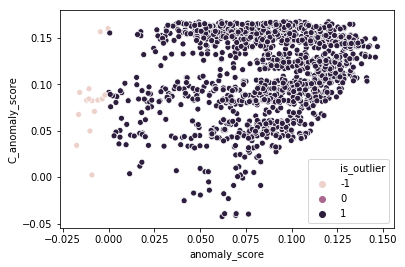

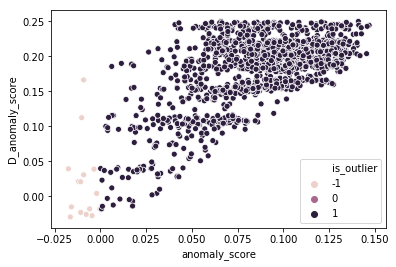

In [18]:
for var in 'A B C D'.split():
    sns.scatterplot(x='anomaly_score', y="{}_anomaly_score".format(var), hue="is_outlier",data=df_train)
    plt.legend()
    plt.show()

In [24]:
individual_scores = 'A_anomaly_score B_anomaly_score C_anomaly_score D_anomaly_score'.split()
df_train[df_train['anomaly_score'] < 0][individual_scores].rank(axis = 1)

,A_anomaly_score,B_anomaly_score,C_anomaly_score,D_anomaly_score
2010-09-05,2.0,4.0,3.0,1.0
2010-09-07,2.0,4.0,3.0,1.0
2010-10-07,2.0,4.0,3.0,1.0
2010-10-08,2.0,4.0,3.0,1.0
2012-10-10,1.0,4.0,2.0,3.0
2013-01-03,4.0,3.0,1.0,2.0
2013-04-14,3.0,4.0,2.0,1.0
2013-04-15,3.0,4.0,2.0,1.0
2013-04-16,3.0,4.0,2.0,1.0
2013-04-17,3.0,4.0,2.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae1fe3fda0>,
      dtype=object)

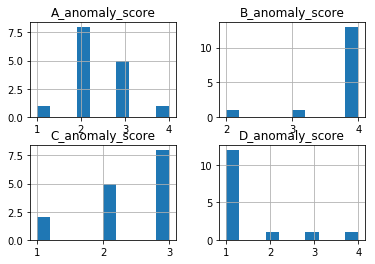

In [28]:
# Show how often each variable has highest inidividual rank when global outlier is detected
df_train[df_train['anomaly_score'] < 0][individual_scores].rank(axis = 1).hist()

In [29]:
df_train.describe()

,A,B,C,D,A_diff,B_diff,C_diff,D_diff,A_pct_change,B_pct_change,C_pct_change,D_pct_change,is_outlier,anomaly_score,A_anomaly_score,B_anomaly_score,C_anomaly_score,D_anomaly_score
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,6.066413,39.516713,-1.987831,26.449278,0.002590,0.036774,-0.025204,0.002969,-0.115025,0.010303,0.021375,0.011027,0.979466,0.087673,0.147781,0.153209,0.114792,0.181944
std,11.667208,18.322633,17.374253,9.324315,1.005228,0.970263,0.954200,1.152824,3.517031,0.210719,3.267661,0.304275,0.201678,0.031793,0.043185,0.044037,0.042382,0.050996
min,-15.235862,0.081650,-41.247318,0.068662,-3.214655,-3.161716,-3.125269,-4.420990,-75.010741,-0.836684,-22.922148,-0.972360,-1.000000,-0.017443,-0.037842,-0.034104,-0.042485,-0.029569
25%,-1.992817,27.810473,-14.632618,20.447762,-0.651226,-0.625098,-0.699156,-0.615211,-0.097899,-0.016946,-0.058706,-0.024521,1.000000,0.067515,0.121931,0.127821,0.086688,0.159282
50%,2.717536,36.657572,1.980826,25.614533,0.013194,0.054283,-0.039300,-0.003086,-0.008142,0.001606,0.000904,-0.000109,1.000000,0.091299,0.155072,0.161486,0.123686,0.194409
75%,13.990394,56.954787,11.712493,33.238335,0.672314,0.692044,0.643549,0.632825,0.075838,0.018489,0.053098,0.023324,1.000000,0.112467,0.172951,0.190394,0.151233,0.215839
max,34.205121,74.250534,23.858113,50.000000,3.134038,4.216318,3.254099,4.463153,75.769542,7.331005,99.325340,11.083123,1.000000,0.146865,0.213481,0.212402,0.167381,0.250107


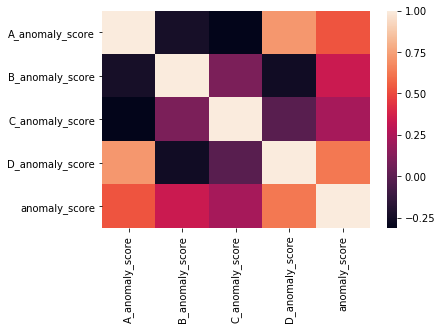

In [27]:
sns.heatmap(df_train[individual_scores + ['anomaly_score'] ].corr())

# Min-Max Scale individual scores columns

In [33]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
scaler = MinMaxScaler()
scaler.fit(df_train[individual_scores])


array([[0.9647531 , 0.06249643, 0.95547439, 0.97762162],
       [0.95069944, 0.03321293, 0.84868486, 0.96911683],
       [0.95799598, 0.06613463, 0.92434531, 0.97143816],
       ...,
       [0.83309734, 0.81399892, 0.49723852, 0.79032378],
       [0.84279548, 0.81970607, 0.42469751, 0.77280026],
       [0.79396884, 0.71394839, 0.49088193, 0.77157878]])

In [42]:
df_train[individual_scores] = scaler.transform(df_train[individual_scores])

/home/ejohnson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ejohnson/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae258b1048>,
      dtype=object)

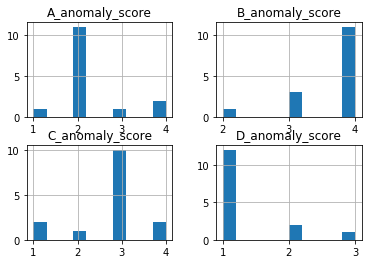

In [43]:
df_train[df_train['anomaly_score'] < 0][individual_scores].rank(axis = 1).hist()

In [44]:
df_train[df_train['anomaly_score'] < 0][individual_scores].rank(axis = 1)

,A_anomaly_score,B_anomaly_score,C_anomaly_score,D_anomaly_score
2010-09-05,2.0,3.0,4.0,1.0
2010-09-07,2.0,3.0,4.0,1.0
2010-10-07,2.0,4.0,3.0,1.0
2010-10-08,2.0,4.0,3.0,1.0
2012-10-10,1.0,4.0,3.0,2.0
2013-01-03,4.0,3.0,1.0,2.0
2013-04-14,3.0,4.0,2.0,1.0
2013-04-15,2.0,4.0,3.0,1.0
2013-04-16,2.0,4.0,3.0,1.0
2013-04-17,2.0,4.0,3.0,1.0
